In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cdart99/food20dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 309s 9s/step - accuracy: 0.1728 - loss: 3.0204 - val_accuracy: 0.6357 - val_loss: 1.2450 - learning_rate: 0.0100
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 309s 8s/step - accuracy: 0.6034 - loss: 1.3571 - val_accuracy: 0.7107 - val_loss: 0.9919 - learning_rate: 0.0100
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.6464 - loss: 1.1174 - val_accuracy: 0.7536 - val_loss: 0.8619 - learning_rate: 0.0100
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.7167 - loss: 0.8958 - val_accuracy: 0.7536 - val_loss: 0.7803 - learning_rate: 0.0100
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 285s 8s/step - accuracy: 0.7453 - loss: 0.7578 - val_accuracy: 0.7714 - val_loss: 0.7408 - learning_rate: 0.0100
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 327s 8s/step - accuracy: 0.7848 - loss: 0.6609 - val_accuracy: 0.7786 - val_loss: 0.7708 - learning_rate: 0.0100
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 255s 7s/step - accuracy: 0.7957 - loss: 0.5477 - val_acc

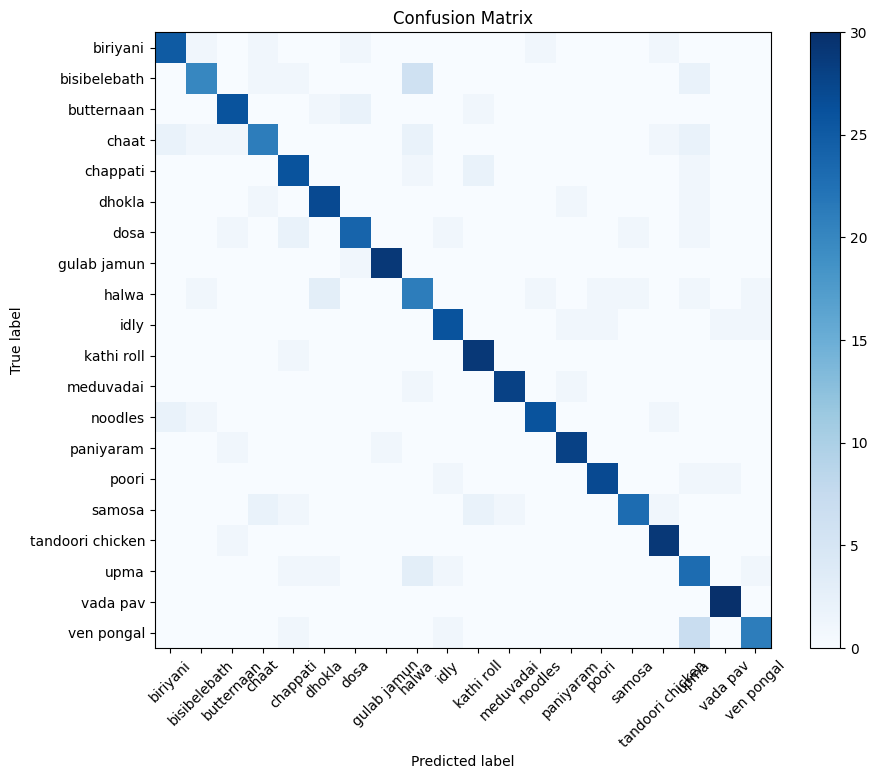

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Paths to your dataset
base_dir = '/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset'
train_dir = os.path.join(base_dir, 'train_set')
test_dir = os.path.join(base_dir, 'test_set')

# Load and preprocess data
def load_data(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))  # Ensure consistent order of class names

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(class_names.index(label))

    return np.array(images), np.array(labels), class_names

# Load training and testing data
x_train, y_train, class_names = load_data(train_dir)
x_test, y_test, _ = load_data(test_dir)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert labels to categorical (One-hot encoding)
y_train = to_categorical(y_train, num_classes=len(class_names))
y_val = to_categorical(y_val, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

# Build the model using ResNet50V2 as the base
def create_model():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

# Compile the model
model = create_model()
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler to adjust learning rate dynamically
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

# Callbacks for better training
callbacks = [
    LearningRateScheduler(lr_scheduler),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix visualization
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Predicted Food: vada pav


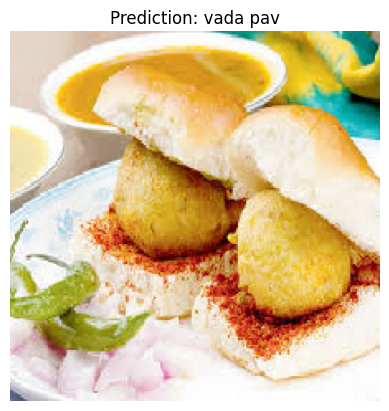

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model (adjust path if needed)
#model = load_model('food_classification_model')

# List of food categories (ensure they match the model's output classes)
categories = [
    'biriyani', 'bisibelebath', 'butternaan', 'chaat', 'chappati', 'dhokla',
    'dosa', 'gulab jamun', 'halwa', 'idly', 'kathi roll', 'meduvadai',
    'noodles', 'paniyaram', 'poori', 'samosa', 'tandoori chicken',
    'upma', 'vada pav', 'ven pongal'
]

def predict_food(image_path):
    """Preprocess the input image, predict its class, and print the result."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the max value

    # Print the prediction result
    print(f"Predicted Food: {categories[predicted_class]}")

    # Optionally: Display the image along with the prediction
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f"Prediction: {categories[predicted_class]}")
    plt.axis('off')
    plt.show()

# Test the function with your image
predict_food('/content/vadapavtrain (10).jpeg')  # Replace with your image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Predicted Food: idly


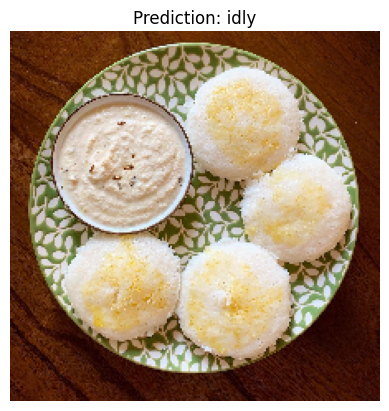

In [ ]:
def predict_food1(image_path):
    """Preprocess the input image, predict its class, and print the result."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the max value

    # Print the prediction result
    print(f"Predicted Food: {categories[predicted_class]}")

    # Optionally: Display the image along with the prediction
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f"Prediction: {categories[predicted_class]}")
    plt.axis('off')
    plt.show()

# Test the function with your image
predict_food1('/content/idlytest (6).jpg')  # Replace with your image path

19/19 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step


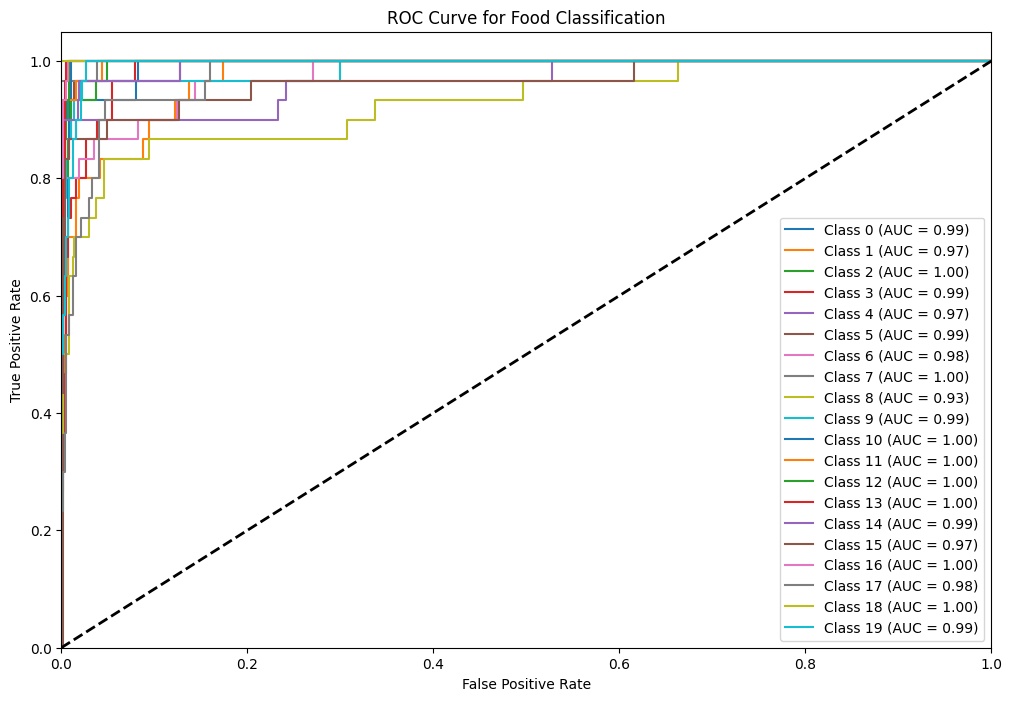

AUC results saved to 'AUC_results.xlsx'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the test set
y_pred_probs = model.predict(x_test)  # Shape: (num_samples, num_classes)

# Ensure y_test is in numerical form
y_test_numeric = np.argmax(y_test, axis=1)  # Convert one-hot to numeric labels

# Initialize lists to store FPR, TPR, and AUC values
fpr_list = []
tpr_list = []
auc_list = []

# Plot ROC for each class
plt.figure(figsize=(12, 8))
for i in range(20):  # Assuming 20 food categories
    # Get the true binary labels for this class (one-vs-rest)
    y_true = (y_test_numeric == i).astype(int)

    # Get the predicted probabilities for this class
    y_pred = y_pred_probs[:, i]

    # Calculate FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Food Classification')
plt.legend(loc='lower right')
plt.show()

# Save AUC values to an Excel file
auc_data = {'Class': [f'Class {i}' for i in range(20)], 'AUC': auc_list}
auc_df = pd.DataFrame(auc_data)
auc_df.to_excel('AUC_results.xlsx', index=False)

print("AUC results saved to 'AUC_results.xlsx'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted Food: vada pav
Nutrients for vada pav:
Calories: 300, Fat: 15, Carbs: 35, Protein: 10


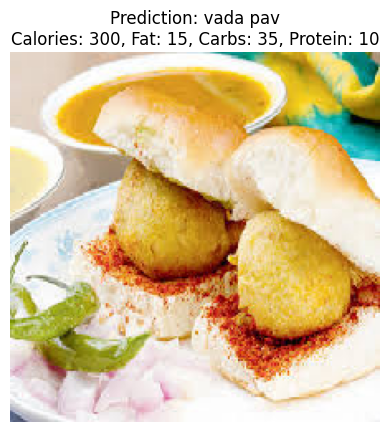

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model (adjust path if needed)
#model = load_model('food_classification_model')  # Adjust the model path accordingly

# List of food categories (ensure they match the model's output classes)
categories = [
    'biriyani', 'bisibelebath', 'butternaan', 'chaat', 'chappati', 'dhokla',
    'dosa', 'gulab jamun', 'halwa', 'idly', 'kathi roll', 'meduvadai',
    'noodles', 'paniyaram', 'poori', 'samosa', 'tandoori chicken',
    'upma', 'vada pav', 'ven pongal'
]

# Nutrient information dictionary
food_nutrients = {
    "biriyani": {"calories": 400, "fat": 20, "carbs": 50, "protein": 20},
    "bisibelebath": {"calories": 300, "fat": 15, "carbs": 40, "protein": 15},
    "butternaan": {"calories": 250, "fat": 12, "carbs": 30, "protein": 10},
    "chaat": {"calories": 200, "fat": 10, "carbs": 25, "protein": 5},
    "chappati": {"calories": 150, "fat": 5, "carbs": 20, "protein": 5},
    "dhokla": {"calories": 150, "fat": 5, "carbs": 20, "protein": 5},
    "dosa": {"calories": 200, "fat": 10, "carbs": 30, "protein": 10},
    "gulab jamun": {"calories": 250, "fat": 15, "carbs": 30, "protein": 5},
    "halwa": {"calories": 300, "fat": 20, "carbs": 40, "protein": 5},
    "idly": {"calories": 100, "fat": 2, "carbs": 20, "protein": 5},
    "kathi roll": {"calories": 300, "fat": 15, "carbs": 35, "protein": 15},
    "meduvadai": {"calories": 150, "fat": 7, "carbs": 15, "protein": 5},
    "noodles": {"calories": 300, "fat": 15, "carbs": 40, "protein": 10},
    "paniyaram": {"calories": 100, "fat": 3, "carbs": 15, "protein": 5},
    "poori": {"calories": 200, "fat": 10, "carbs": 25, "protein": 5},
    "samosa": {"calories": 250, "fat": 15, "carbs": 30, "protein": 10},
    "tandoori chicken": {"calories": 300, "fat": 15, "carbs": 5, "protein": 30},
    "upma": {"calories": 200, "fat": 8, "carbs": 25, "protein": 10},
    "vada pav": {"calories": 300, "fat": 15, "carbs": 35, "protein": 10},
    "ven pongal": {"calories": 250, "fat": 10, "carbs": 30, "protein": 10},
}

def predict_food(image_path):
    """Preprocess the input image, predict its class, and print the result with nutrients."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the max value
    predicted_class = categories[predicted_class_index]

    # Print the prediction result
    print(f"Predicted Food: {predicted_class}")

    # Display the nutrients
    nutrients = food_nutrients[predicted_class]
    print(f"Nutrients for {predicted_class}:")
    print(f"Calories: {nutrients['calories']}, Fat: {nutrients['fat']}, Carbs: {nutrients['carbs']}, Protein: {nutrients['protein']}")

    # Optionally: Display the image along with the prediction and nutrients
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nCalories: {nutrients['calories']}, Fat: {nutrients['fat']}, Carbs: {nutrients['carbs']}, Protein: {nutrients['protein']}")
    plt.axis('off')
    plt.show()

# Test the function with your image
predict_food('/content/vadapavtrain (10).jpeg')  # Replace with your image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
Predicted Food: biriyani
Nutrients for biriyani:
Calories: 400, Fat: 20, Carbs: 50, Protein: 20


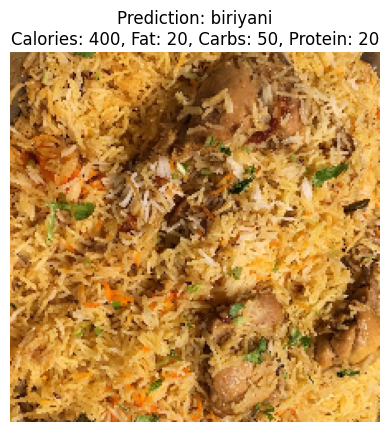

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model (adjust path if needed)
#model = load_model('food_classification_model')  # Adjust the model path accordingly

# List of food categories (ensure they match the model's output classes)
categories = [
    'biriyani', 'bisibelebath', 'butternaan', 'chaat', 'chappati', 'dhokla',
    'dosa', 'gulab jamun', 'halwa', 'idly', 'kathi roll', 'meduvadai',
    'noodles', 'paniyaram', 'poori', 'samosa', 'tandoori chicken',
    'upma', 'vada pav', 'ven pongal'
]

# Nutrient information dictionary
food_nutrients = {
    "biriyani": {"calories": 400, "fat": 20, "carbs": 50, "protein": 20},
    "bisibelebath": {"calories": 300, "fat": 15, "carbs": 40, "protein": 15},
    "butternaan": {"calories": 250, "fat": 12, "carbs": 30, "protein": 10},
    "chaat": {"calories": 200, "fat": 10, "carbs": 25, "protein": 5},
    "chappati": {"calories": 150, "fat": 5, "carbs": 20, "protein": 5},
    "dhokla": {"calories": 150, "fat": 5, "carbs": 20, "protein": 5},
    "dosa": {"calories": 200, "fat": 10, "carbs": 30, "protein": 10},
    "gulab jamun": {"calories": 250, "fat": 15, "carbs": 30, "protein": 5},
    "halwa": {"calories": 300, "fat": 20, "carbs": 40, "protein": 5},
    "idly": {"calories": 100, "fat": 2, "carbs": 20, "protein": 5},
    "kathi roll": {"calories": 300, "fat": 15, "carbs": 35, "protein": 15},
    "meduvadai": {"calories": 150, "fat": 7, "carbs": 15, "protein": 5},
    "noodles": {"calories": 300, "fat": 15, "carbs": 40, "protein": 10},
    "paniyaram": {"calories": 100, "fat": 3, "carbs": 15, "protein": 5},
    "poori": {"calories": 200, "fat": 10, "carbs": 25, "protein": 5},
    "samosa": {"calories": 250, "fat": 15, "carbs": 30, "protein": 10},
    "tandoori chicken": {"calories": 300, "fat": 15, "carbs": 5, "protein": 30},
    "upma": {"calories": 200, "fat": 8, "carbs": 25, "protein": 10},
    "vada pav": {"calories": 300, "fat": 15, "carbs": 35, "protein": 10},
    "ven pongal": {"calories": 250, "fat": 10, "carbs": 30, "protein": 10},
}

def predict_food(image_path):
    """Preprocess the input image, predict its class, and print the result with nutrients."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the max value
    predicted_class = categories[predicted_class_index]

    # Print the prediction result
    print(f"Predicted Food: {predicted_class}")

    # Display the nutrients
    nutrients = food_nutrients[predicted_class]
    print(f"Nutrients for {predicted_class}:")
    print(f"Calories: {nutrients['calories']}, Fat: {nutrients['fat']}, Carbs: {nutrients['carbs']}, Protein: {nutrients['protein']}")

    # Optionally: Display the image along with the prediction and nutrients
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nCalories: {nutrients['calories']}, Fat: {nutrients['fat']}, Carbs: {nutrients['carbs']}, Protein: {nutrients['protein']}")
    plt.axis('off')
    plt.show()

# Test the function with your image
predict_food('/content/biriyanitest (19).jpg')  # Replace with your image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Predicted Food: halwa
Nutrients for halwa:
Calories: 300, Fat: 20, Carbs: 40, Protein: 5


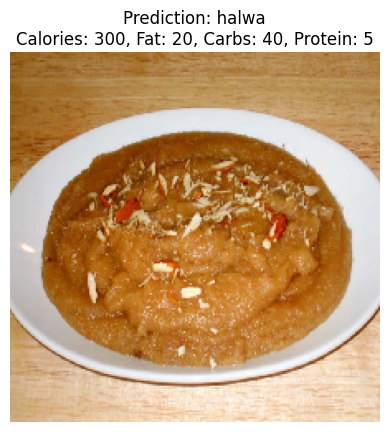

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model (adjust path if needed)
#model = load_model('food_classification_model')  # Adjust the model path accordingly

# List of food categories (ensure they match the model's output classes)
categories = [
    'biriyani', 'bisibelebath', 'butternaan', 'chaat', 'chappati', 'dhokla',
    'dosa', 'gulab jamun', 'halwa', 'idly', 'kathi roll', 'meduvadai',
    'noodles', 'paniyaram', 'poori', 'samosa', 'tandoori chicken',
    'upma', 'vada pav', 'ven pongal'
]

# Nutrient information dictionary
food_nutrients = {
    "biriyani": {"calories": 400, "fat": 20, "carbs": 50, "protein": 20},
    "bisibelebath": {"calories": 300, "fat": 15, "carbs": 40, "protein": 15},
    "butternaan": {"calories": 250, "fat": 12, "carbs": 30, "protein": 10},
    "chaat": {"calories": 200, "fat": 10, "carbs": 25, "protein": 5},
    "chappati": {"calories": 150, "fat": 5, "carbs": 20, "protein": 5},
    "dhokla": {"calories": 150, "fat": 5, "carbs": 20, "protein": 5},
    "dosa": {"calories": 200, "fat": 10, "carbs": 30, "protein": 10},
    "gulab jamun": {"calories": 250, "fat": 15, "carbs": 30, "protein": 5},
    "halwa": {"calories": 300, "fat": 20, "carbs": 40, "protein": 5},
    "idly": {"calories": 100, "fat": 2, "carbs": 20, "protein": 5},
    "kathi roll": {"calories": 300, "fat": 15, "carbs": 35, "protein": 15},
    "meduvadai": {"calories": 150, "fat": 7, "carbs": 15, "protein": 5},
    "noodles": {"calories": 300, "fat": 15, "carbs": 40, "protein": 10},
    "paniyaram": {"calories": 100, "fat": 3, "carbs": 15, "protein": 5},
    "poori": {"calories": 200, "fat": 10, "carbs": 25, "protein": 5},
    "samosa": {"calories": 250, "fat": 15, "carbs": 30, "protein": 10},
    "tandoori chicken": {"calories": 300, "fat": 15, "carbs": 5, "protein": 30},
    "upma": {"calories": 200, "fat": 8, "carbs": 25, "protein": 10},
    "vada pav": {"calories": 300, "fat": 15, "carbs": 35, "protein": 10},
    "ven pongal": {"calories": 250, "fat": 10, "carbs": 30, "protein": 10},
}

def predict_food(image_path):
    """Preprocess the input image, predict its class, and print the result with nutrients."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the max value
    predicted_class = categories[predicted_class_index]

    # Print the prediction result
    print(f"Predicted Food: {predicted_class}")

    # Display the nutrients
    nutrients = food_nutrients[predicted_class]
    print(f"Nutrients for {predicted_class}:")
    print(f"Calories: {nutrients['calories']}, Fat: {nutrients['fat']}, Carbs: {nutrients['carbs']}, Protein: {nutrients['protein']}")

    # Optionally: Display the image along with the prediction and nutrients
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}\nCalories: {nutrients['calories']}, Fat: {nutrients['fat']}, Carbs: {nutrients['carbs']}, Protein: {nutrients['protein']}")
    plt.axis('off')
    plt.show()

# Test the function with your image
predict_food('/content/halwatest (16).jpg')  # Replace with your image path


In [ ]:
recipes = {
    "biriyani": [
        {
            "title": "Chicken Biryani",
            "ingredients": ["chicken", "rice", "onions", "spices", "yogurt"],
            "instructions": "Cook chicken with spices, layer with rice, and cook on low heat."
        }
    ],
    "idly": [
        {
            "title": "Traditional Idly",
            "ingredients": ["idly batter", "water", "oil"],
            "instructions": "Steam idly batter in molds for 10-15 minutes."
        }
    ],
    "bisibelebath": [
        {
            "title": "Classic Bisi Bele Bath",
            "ingredients": ["lentils", "rice", "vegetables", "spices", "ghee"],
            "instructions": "Cook lentils and rice, add vegetables and spices, and temper with ghee."
        }
    ],
    "butternaan": [
        {
            "title": "Fluffy Butter Naan",
            "ingredients": ["flour", "water", "butter", "yogurt"],
            "instructions": "Knead dough, roll into balls, and cook on a tawa with butter."
        }
    ],
    "chaat": [
        {
            "title": "Spicy Pani Puri",
            "ingredients": ["puri shells", "water", "tamarind chutney", "mint chutney", "spices"],
            "instructions": "Fill puri shells with water and chutneys, add spices."
        }
    ],
    "chappati": [
        {
            "title": "Whole Wheat Chapatti",
            "ingredients": ["whole wheat flour", "water", "oil"],
            "instructions": "Knead dough, roll into thin circles, and cook on a tawa."
        }
    ],
    "dhokla": [
        {
            "title": "Savory Dhokla",
            "ingredients": ["gram flour", "yogurt", "lemon juice", "baking soda", "water"],
            "instructions": "Mix ingredients, steam, and serve with chutney."
        }
    ],
    "dosa": [
        {
            "title": "Crispy Masala Dosa",
            "ingredients": ["dosa batter", "potato masala"],
            "instructions": "Pour batter on a hot griddle, spread potato masala, and cook until crispy."
        }
    ],
    "gulab jamun": [
        {
            "title": "Sweet Gulab Jamun",
            "ingredients": ["milk powder", "sugar", "cardamom powder", "oil"],
            "instructions": "Make dough, fry into balls, and soak in sugar syrup."
        }
    ],
    "halwa": [
        {
            "title": "Rich Besan Halwa",
            "ingredients": ["gram flour", "ghee", "sugar", "cardamom powder"],
            "instructions": "Roast gram flour in ghee, add sugar and cardamom, and cook until thick."
        }
    ],
    # ... continue adding recipes for the remaining food items
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Predicted Food: halwa


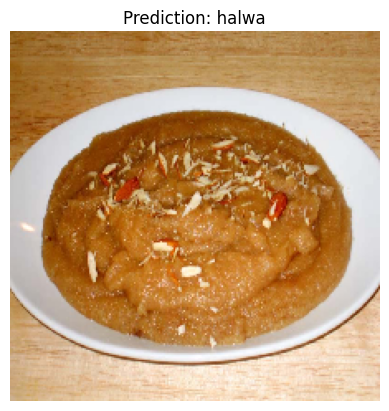

Recipe suggestions for halwa:
- Rich Besan Halwa:
  Ingredients: gram flour, ghee, sugar, cardamom powder
  Instructions: Roast gram flour in ghee, add sugar and cardamom, and cook until thick.



In [ ]:
def predict_food(image_path):
    """Preprocess the input image, predict its class, and print the result."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the max value

    # Print the prediction result
    food_name = categories[predicted_class]
    print(f"Predicted Food: {food_name}")

    # Display the image with prediction
    plt.imshow(img)
    plt.title(f"Prediction: {food_name}")
    plt.axis('off')
    plt.show()

    # Provide recipe suggestions
    provide_recipe_suggestions(food_name)

def provide_recipe_suggestions(food_name):
    """Display recipe suggestions for the predicted food."""
    if food_name in recipes:
        print(f"Recipe suggestions for {food_name}:")
        for recipe in recipes[food_name]:
            print(f"- {recipe['title']}:")
            print(f"  Ingredients: {', '.join(recipe['ingredients'])}")
            print(f"  Instructions: {recipe['instructions']}\n")
    else:
        print(f"No recipes found for {food_name}.")
# Test the function with your image
predict_food('/content/halwatest (16).jpg')  # Replace with your image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


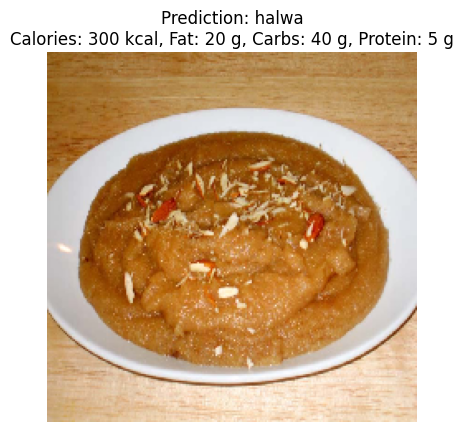

Recipe suggestions for halwa:
- Rich Besan Halwa:
  Ingredients: gram flour, ghee, sugar, cardamom powder
  Instructions: Roast gram flour in ghee, add sugar and cardamom, and cook until thick.



In [ ]:
def predict_food2(image_path):
    """Preprocess the input image, predict its class, and display the result."""

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match input shape

    # Predict the food category
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the max value

    # Get food name and nutrients
    food_name = categories[predicted_class]
    nutrients = food_nutrients.get(food_name, {})

    # Prepare nutrients information for the title
    nutrients_info = f"Calories: {nutrients.get('calories', 'N/A')} kcal, " \
                     f"Fat: {nutrients.get('fat', 'N/A')} g, " \
                     f"Carbs: {nutrients.get('carbs', 'N/A')} g, " \
                     f"Protein: {nutrients.get('protein', 'N/A')} g"

    # Display the image with prediction and nutrients information
    plt.imshow(img)
    plt.title(f"Prediction: {food_name}\n{nutrients_info}")
    plt.axis('off')
    plt.show()

    # Provide recipe suggestions
    provide_recipe_suggestions1(food_name)

def provide_recipe_suggestions1(food_name):
    """Display recipe suggestions for the predicted food."""
    if food_name in recipes:
        print(f"Recipe suggestions for {food_name}:")
        for recipe in recipes[food_name]:
            print(f"- {recipe['title']}:")
            print(f"  Ingredients: {', '.join(recipe['ingredients'])}")
            print(f"  Instructions: {recipe['instructions']}\n")
    else:
        print(f"No recipes found for {food_name}.")

# Test the function with your image
predict_food2('/content/halwatest (16).jpg')

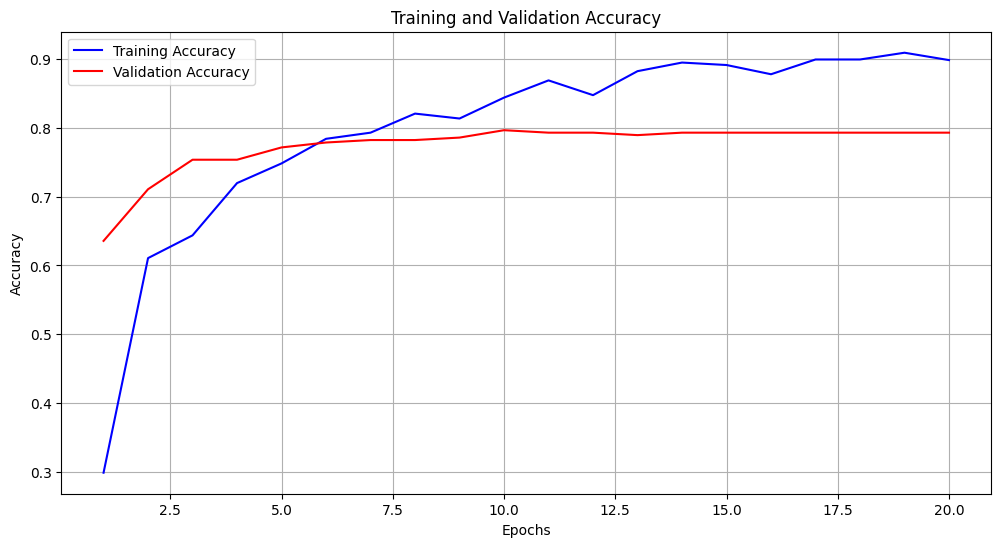

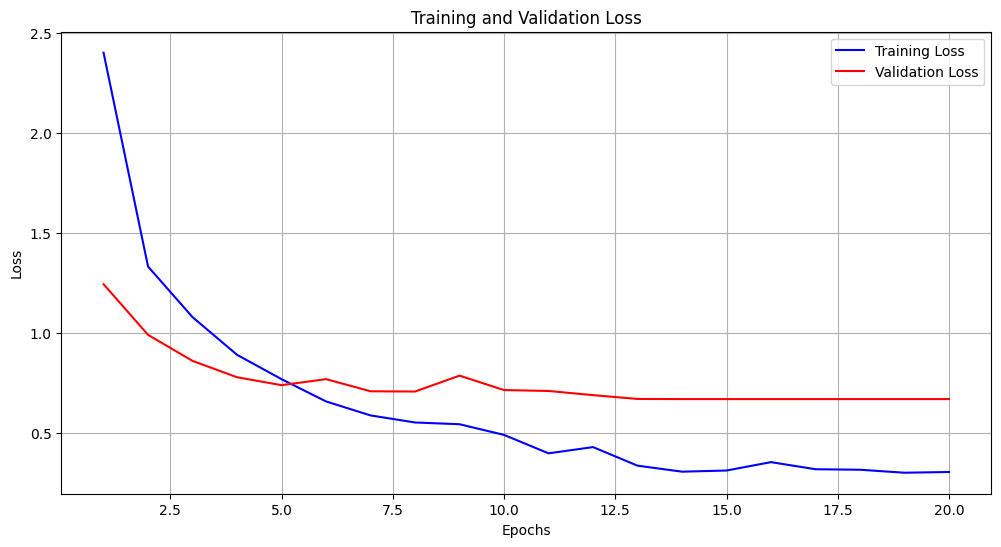

Epoch results saved to 'epoch_results.xlsx'


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'history' is the object returned by model.fit()
history_data = history.history

# Extract accuracy, validation accuracy, loss, and validation loss
epochs = range(1, len(history_data['accuracy']) + 1)
train_accuracy = history_data['accuracy']
val_accuracy = history_data['val_accuracy']
train_loss = history_data['loss']
val_loss = history_data['val_loss']

# Plot Accuracy vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save epoch-wise data to Excel
epoch_data = {
    'Epoch': epochs,
    'Training Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy,
    'Training Loss': train_loss,
    'Validation Loss': val_loss
}
epoch_df = pd.DataFrame(epoch_data)
epoch_df.to_excel('epoch_results.xlsx', index=False)

print("Epoch results saved to 'epoch_results.xlsx'")


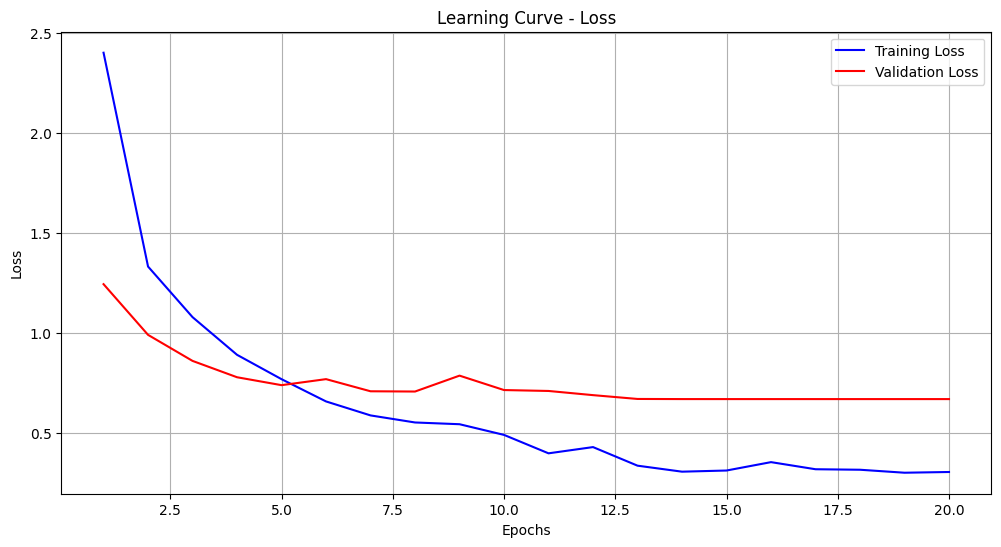

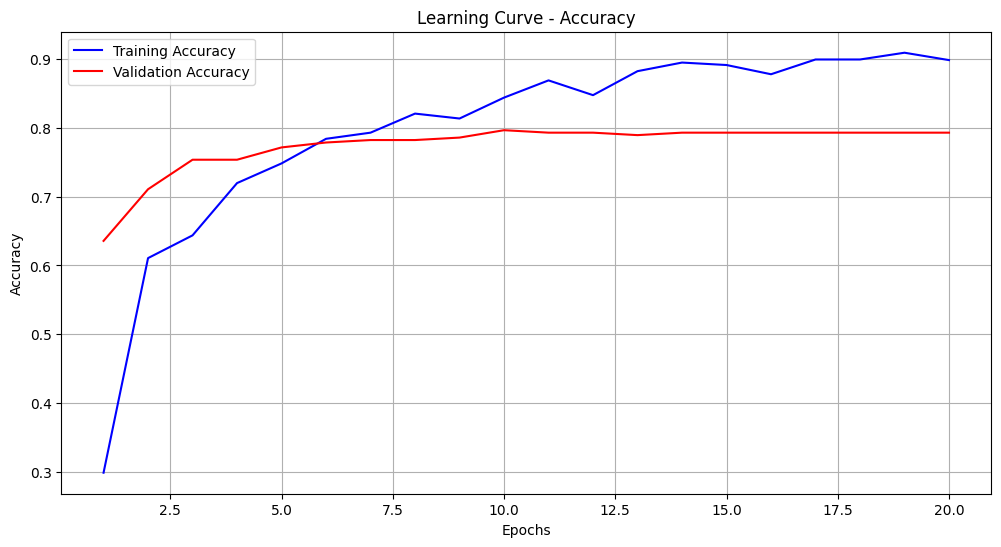

Learning curve results saved to 'learning_curve_results.xlsx'


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract data from the history object
history_data = history.history

# Extract the relevant metrics
epochs = range(1, len(history_data['loss']) + 1)
train_loss = history_data['loss']
val_loss = history_data['val_loss']
train_accuracy = history_data['accuracy']
val_accuracy = history_data['val_accuracy']

# Plot the Learning Curve for Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Learning Curve for Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save learning curve data to Excel
learning_curve_data = {
    'Epoch': epochs,
    'Training Loss': train_loss,
    'Validation Loss': val_loss,
    'Training Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy
}
learning_curve_df = pd.DataFrame(learning_curve_data)
learning_curve_df.to_excel('learning_curve_results.xlsx', index=False)

print("Learning curve results saved to 'learning_curve_results.xlsx'")


19/19 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step


<Figure size 1000x800 with 0 Axes>

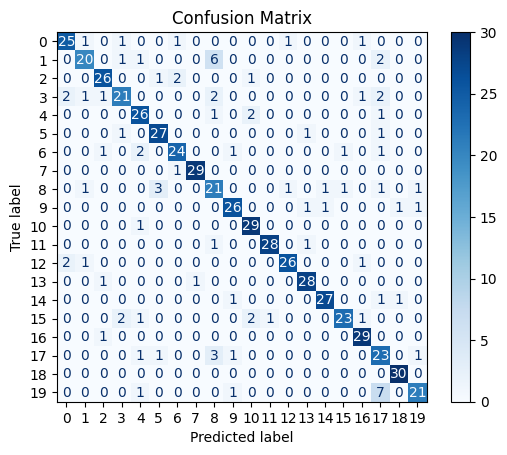

Confusion matrix saved to 'confusion_matrix.xlsx'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming `x_test` and `y_test` are already loaded and the model is trained
# Predicting on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title('Confusion Matrix')
plt.show()

# Save the confusion matrix to an Excel file
cm_df = pd.DataFrame(cm, index=categories, columns=categories)
cm_df.to_excel('confusion_matrix.xlsx')

print("Confusion matrix saved to 'confusion_matrix.xlsx'")


F1 Score metrics saved to 'f1_score_metrics.xlsx'


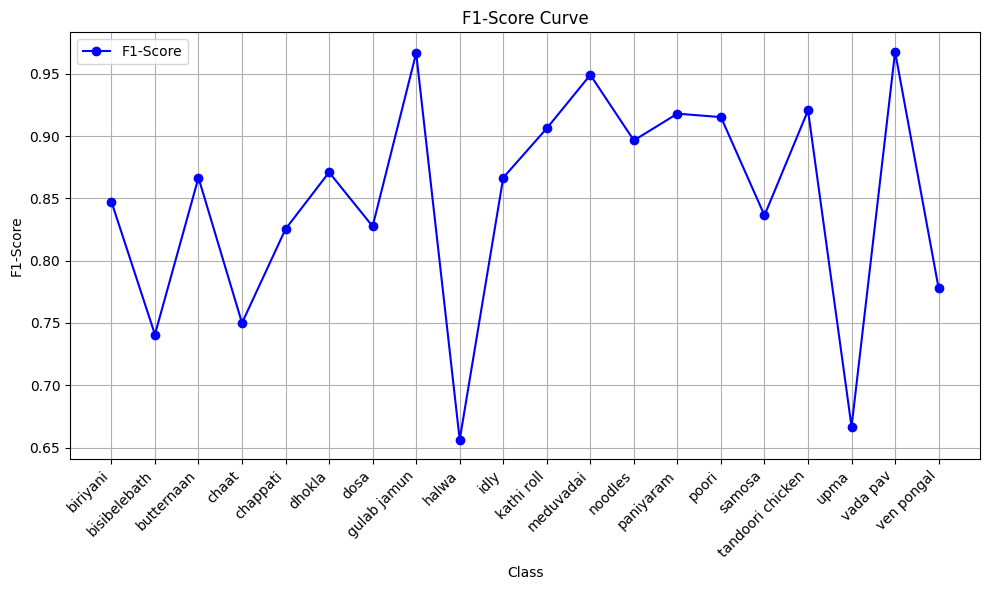

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Predict on the test set
#y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

# Calculate Precision, Recall, F1-Score, and Support
precision, recall, f1_score, support = precision_recall_fscore_support(
    y_true, y_pred_classes, average=None, zero_division=0
)

# Create a DataFrame for export
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'Support': support
}, index=categories)  # Use your class names as index

# Save to Excel
metrics_df.to_excel('f1_score_metrics.xlsx')
print("F1 Score metrics saved to 'f1_score_metrics.xlsx'")

# Plot F1 Score Curve
plt.figure(figsize=(10, 6))
plt.plot(categories, f1_score, marker='o', linestyle='-', color='b', label='F1-Score')
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Dataset distribution saved to 'dataset_distribution.xlsx'


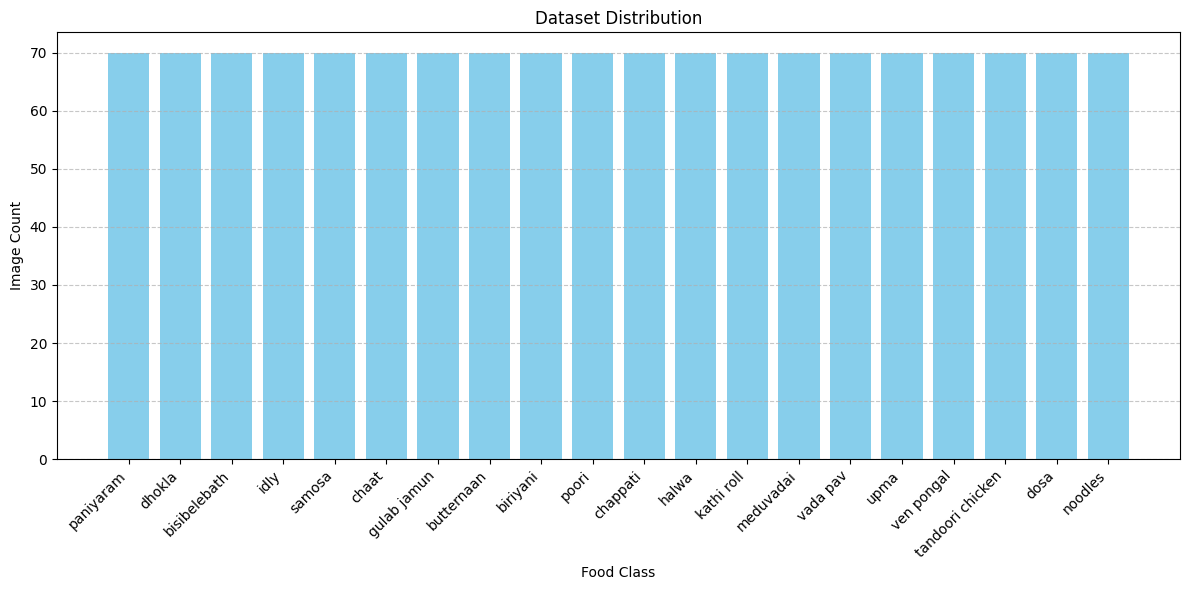

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to your dataset (modify if needed)
dataset_path = "/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set"

# Get the count of images in each class folder
data_distribution = {
    category: len(os.listdir(os.path.join(dataset_path, category)))
    for category in os.listdir(dataset_path)
}

# Convert the distribution to a DataFrame
distribution_df = pd.DataFrame(list(data_distribution.items()), columns=['Class', 'Image Count'])

# Save to Excel
distribution_df.to_excel('dataset_distribution.xlsx', index=False)
print("Dataset distribution saved to 'dataset_distribution.xlsx'")

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(distribution_df['Class'], distribution_df['Image Count'], color='skyblue')
plt.xticks(rotation=45, ha='right')  # Rotate class names for readability
plt.xlabel('Food Class')
plt.ylabel('Image Count')
plt.title('Dataset Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


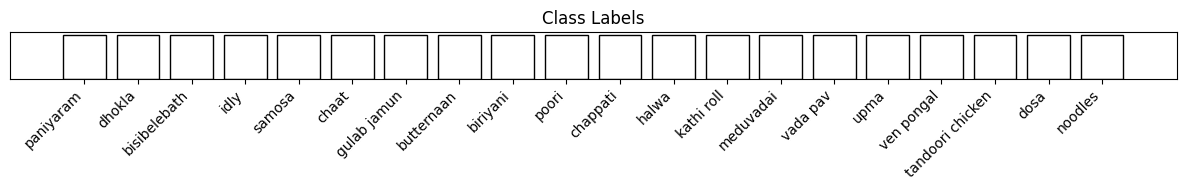

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to your dataset (modify if needed)
#dataset_path = "path/to/food20dataset/train_set"

# Get the list of categories (class labels) from the dataset folders
categories = os.listdir(dataset_path)

# Plot a labels-only graph
plt.figure(figsize=(12, 2))  # Adjust height for a cleaner look
plt.bar(categories, [1]*len(categories), color='white', edgecolor='black')  # Invisible bars
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.yticks([])  # Hide y-axis ticks
plt.title('Class Labels')
plt.tight_layout()

# Show the graph
plt.show()


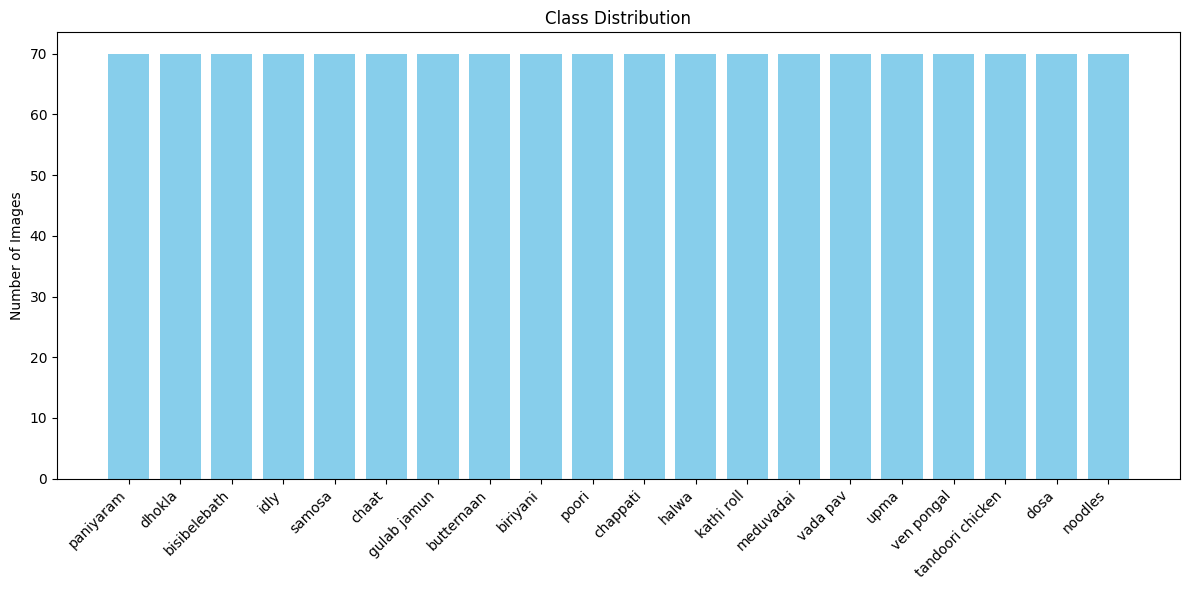

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to your dataset (modify if needed)
#dataset_path = "path/to/food20dataset/train_set"

# Count the number of images in each category
class_counts = {}
for category in os.listdir(dataset_path):
    class_counts[category] = len(os.listdir(os.path.join(dataset_path, category)))

# Create a bar graph
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

# Create a DataFrame and save to Excel
df_class_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
df_class_counts.to_excel('class_distribution.xlsx', index=False)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Assuming you have X_test, y_test available and the model is already loaded
# Example: If your y_test is categorical labels, convert it to one-hot encoding
y_test_onehot = to_categorical(y_test, num_classes=20)  # Adjust '20' to match your class count

# Get predictions (probabilities) for the test set
y_pred_probs = model.predict(x_val)

# Initialize lists to store TPR, FPR, and AUC for all classes
tpr_list = []
fpr_list = []
auc_list = []

# Generate ROC curve for each class
for i in range(20):  # Assuming 20 classes
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)

    tpr_list.append(tpr)
    fpr_list.append(fpr)
    auc_list.append(roc_auc)

    # Plot the ROC curve for this class
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i}').plot()

plt.title('ROC Curve for All Classes')
plt.show()

# Save TPR, FPR, and AUC values to Excel for documentation
roc_data = {
    'Class': [f'Class {i}' for i in range(20)],
    'AUC': auc_list,
    'TPR': [list(tpr) for tpr in tpr_list],
    'FPR': [list(fpr) for fpr in fpr_list]
}

# Convert to DataFrame and save to Excel
roc_df = pd.DataFrame(roc_data)
roc_df.to_excel('roc_curve_results.xlsx', index=False)

print("ROC data saved to 'roc_curve_results.xlsx'")


9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step


ValueError: multilabel-indicator format is not supported

In [ ]:
import shutil

# Save the entire model to a directory
model.save('SGDOPtimis_Wokg.h5')
model.save('SGDOPtimis_Wokg2.keras')
# Optional: Save in HDF5 format as well if you prefer
model.save('food_classification_model.h5')

# Zip the model directory for easy download
shutil.make_archive('food_classification_model', 'zip', 'food_classification_model')

# Download the zip file to your local system
from google.colab import files
files.download('food_classification_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

REUSE CODE


In [ ]:
from tensorflow.keras.models import load_model

# Load the SavedModel from a directory
model = load_model('food_classification_model')

# If you used the HDF5 format:
# model = load_model('food_classification_model.h5')

# Evaluate the reloaded model (optional)
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Paths to your dataset
base_dir = '/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset'
train_dir = os.path.join(base_dir, 'train_set')
test_dir = os.path.join(base_dir, 'test_set')

# Load and preprocess data
def load_data(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))  # Ensure consistent order of class names

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(class_names.index(label))

    return np.array(images), np.array(labels), class_names

# Load training and testing data
x_train, y_train, class_names = load_data(train_dir)
x_test, y_test, _ = load_data(test_dir)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert labels to categorical (One-hot encoding)
y_train = to_categorical(y_train, num_classes=len(class_names))
y_val = to_categorical(y_val, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

# Build the model using ResNet50V2 as the base
def create_model():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

# Compile the model
model = create_model()
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler to adjust learning rate dynamically
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

# Callbacks for better training
callbacks = [
    LearningRateScheduler(lr_scheduler),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix visualization

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Paths to your dataset
base_dir = '/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset'
train_dir = os.path.join(base_dir, 'train_set')
test_dir = os.path.join(base_dir, 'test_set')

# Load and preprocess data
def load_data(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))  # Ensure consistent order of class names

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.utils.img_to_array(img)
                images.append(img_array)
                labels.append(class_names.index(label))

    return np.array(images), np.array(labels), class_names

# Load training and testing data
x_train, y_train, class_names = load_data(train_dir)
x_test, y_test, _ = load_data(test_dir)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert labels to categorical (One-hot encoding)
y_train = to_categorical(y_train, num_classes=len(class_names))
y_val = to_categorical(y_val, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

# Build the model using ResNet50V2 as the base
def create_model():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

# Compile the model
model = create_model()
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler to adjust learning rate dynamically
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

# Callbacks for better training
callbacks = [
    LearningRateScheduler(lr_scheduler),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


SyntaxError: invalid syntax (<ipython-input-3-a318cdbfffa8>, line 104)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (41).jpg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (14).jpeg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (20).jpeg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (9).jpg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (2).jpg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (1).jpg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (11).jpeg
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram/paniyaramtrain (16).jpg
/root/.cache/kag

In [ ]:
import seaborn as sns
import cv2
import keras
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout

In [ ]:
categories = os.listdir('/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/test_set')

img_size= 224

def data_gen(data_dir):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        print(path)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                # Check if image was loaded successfully
                if img_arr is not None:
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
                else:
                    print(f"Failed to load image: {os.path.join(path, img)}")
            except Exception as e:
                print(e)

    return np.array(data, dtype=object) # Specify dtype=object to handle varying shapes

In [ ]:
train_data= data_gen('/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set')
val_data= data_gen('/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/test_set')

/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/paniyaram
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/dhokla
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/bisibelebath
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/idly
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/samosa
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/chaat
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/gulab jamun
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/butternaan
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/biriyani
/root/.cache/kagglehub/datasets/cdart99/food20dataset/versions/1/food20dataset/train_set/poori
/root/.cache/kagglehub/d

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train_data:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val_data:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import optuna

# Step 1: Define the model creation function with dynamic optimizer and hyperparameters
def create_model(optimizer, learning_rate):
    model = Sequential()
    model.add(Conv2D(128, 3, padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPool2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(20, activation='softmax'))

    # Compile the model with the suggested optimizer and learning rate
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# Step 2: Define the Optuna objective function
def objective(trial):
    # Suggest an optimizer type
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Suggest a learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)

    # Create the optimizer dynamically
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Create and train the model
    model = create_model(optimizer, learning_rate)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=32,  # Fixed batch size, but Optuna can optimize it if needed
        epochs=10,  # Use fewer epochs for optimization speed
        verbose=0
    )

    # Return the final validation loss
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Step 3: Run Optuna optimization
study = optuna.create_study(direction='minimize')  # Minimize validation loss
study.optimize(objective, n_trials=20)  # Run 20 trials

# Step 4: Print the best hyperparameters found
print("Best Hyperparameters:", study.best_params)

# Step 5: Train the final model with the best hyperparameters
best_optimizer_name = study.best_params['optimizer']
best_learning_rate = study.best_params['learning_rate']

# Create the best optimizer
if best_optimizer_name == 'Adam':
    best_optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
elif best_optimizer_name == 'SGD':
    best_optimizer = tf.keras.optimizers.SGD(learning_rate=best_learning_rate)
elif best_optimizer_name == 'RMSprop':
    best_optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_learning_rate)

# Train the final model using the optimized parameters
final_model = create_model(best_optimizer, best_learning_rate)
history = final_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,  # Use the same batch size or optimize further if needed
    epochs=50,  # Full training
    verbose=1
)


[I 2024-10-19 13:17:20,276] A new study created in memory with name: no-name-4f6a6b05-9a7c-4d99-b956-f357b5639133
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
[I 2024-10-19 14:41:58,051] Trial 0 finished with value: 2.1765716075897217 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00012864764708464866}. Best is trial 0 with value: 2.1765716075897217.
[I 2024-10-19 16:04:30,00

In [ ]:
model= Sequential()

model.add(Conv2D(128,3,padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(64,3,padding='same', activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32,3,padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(20,activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,523,764 (24.89 MB)

 Trainable params: 6,523,764 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])
history = model.fit(x_train,y_train,epochs = 50, validation_data = (x_val, y_val))
model.save('/content/drive/MyDrive/Colab Notebooks/Kagle_Model/food_model_final2  .h5')

print("Training completed and model saved.")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


44/44 ━━━━━━━━━━━━━━━━━━━━ 475s 11s/step - accuracy: 0.0670 - loss: 2.9955 - val_accuracy: 0.1533 - val_loss: 2.9208
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 496s 11s/step - accuracy: 0.1379 - loss: 2.8709 - val_accuracy: 0.1650 - val_loss: 2.6353
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 511s 11s/step - accuracy: 0.2330 - loss: 2.5633 - val_accuracy: 0.3017 - val_loss: 2.3805
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 498s 11s/step - accuracy: 0.3730 - loss: 2.2071 - val_accuracy: 0.3600 - val_loss: 2.0490
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 496s 11s/step - accuracy: 0.4994 - loss: 1.7711 - val_accuracy: 0.4300 - val_loss: 1.9370
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 477s 11s/step - accuracy: 0.5587 - loss: 1.5302 - val_accuracy: 0.4333 - val_loss: 1.9377
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 501s 11s/step - accuracy: 0.6649 - loss: 1.1607 - val_accuracy: 0.4567 - val_loss: 1.8586
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 478s 11s/step - accuracy: 0.7666 - loss: 0.9098 - val_accuracy: 0.5000 - val_

Training completed and model saved.


In [ ]:
epochs_range= range(50)

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

fig, axes= plt.subplots(1,2, figsize=(16,6))

ax= axes.ravel()

ax[0].plot(epochs_range, acc, label='trainning accuracy')
ax[0].plot(epochs_range, val_acc, label='validation accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs_range,loss, label='trainning loss')
ax[1].plot(epochs_range, val_loss, label='validation loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

NameError: name 'history' is not defined